In [3]:
!pip install -q -U trl==0.9.6 transformers peft bitsandbytes bert_score

In [44]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [48]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4d0e1f99286fb6dbf2018ec3db4dbde09c7402345b822355f09fb004afaf4e68
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments
)
from trl import SFTTrainer, SFTConfig
from bert_score import score
import gc # Garbage collector для очистки памяти

## 1. Выбор и описание датасета
Для решения задачи была выбрана подвыборка датасета **Amazon Polarity**. Это массив данных, содержащий миллионы пар «Текст отзыва» — «Заголовок».

**Почему этот датасет?**
1.  **Естественная структура:** Поля `content` (вход) и `title` (цель) идеально подходят для задачи Supervised Learning (обучение с учителем).
2.  **Сложность задачи:** Заголовки отзывов часто абстрактивны. Пользователи не просто копируют предложения из текста, а формулируют общий вывод (например, *«Текст: Сломался через день... -> Заголовок: Деньги на ветер»*). Это требует от модели понимания смысла, а не просто копирования.
3.  **Доменная специфика:** Тексты содержат сленг, эмоциональную окраску и неформальный стиль, что делает задачу актуальной для реального бизнеса (маркетплейсы).


In [2]:
print("Библиотеки готовы. GPU:", torch.cuda.get_device_name(0))

dataset_name = "amazon_polarity"
train_size = 2000
test_size = 200

Библиотеки готовы. GPU: Tesla T4


In [3]:
print(f"Загрузка датасета {dataset_name}...")
data = load_dataset(dataset_name, split="train")
data = data.shuffle(seed=42)

train_dataset = data.select(range(train_size))

test_dataset = data.select(range(train_size, train_size + test_size))

Загрузка датасета amazon_polarity...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

## 2. Разведочный анализ данных (EDA)
Перед обучением был проведен анализ длины текстов, чтобы выбрать оптимальные параметры модели (`max_seq_length`).

Графики показывают распределение длины отзывов (Input) и заголовков (Target).
*   **Инфайт:** Большинство отзывов укладываются в 200-300 токенов, однако есть длинные хвосты.
*   **Сжатие:** Коэффициент сжатия (Compression Ratio) очень высокий. Заголовки обычно состоят из 3-10 слов, тогда как отзывы могут быть длиной в 100+ слов. Это подтверждает необходимость жесткого ограничения длины генерации (`max_new_tokens`) и способность модели выделять главное.



=== Начало анализа данных ===

Распределение классов:
label
0    1011
1     989
Name: count, dtype: int64

Статистика по длине отзывов (слов):
count    2000.000000
mean       74.197000
std        41.291545
min        10.000000
25%        39.000000
50%        67.000000
75%       102.000000
max       198.000000
Name: content_words, dtype: float64

Статистика по длине заголовков (слов):
count    2000.000000
mean        4.331500
std         2.596725
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: title_words, dtype: float64


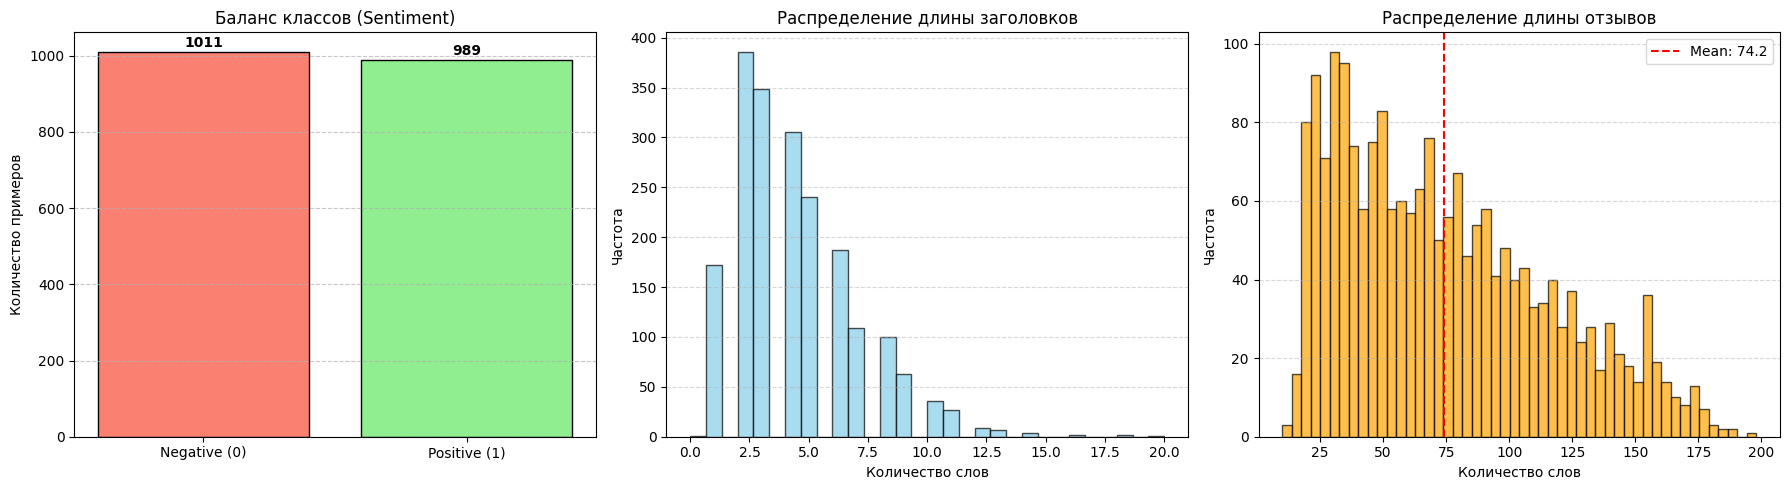


=== Случайные примеры из обучающей выборки ===

[Пример 1] Sent: NEGATIVE
Title: Hard for a kid to put together
Content: I wouldn't buy this puzzle for anyone under 6. It's difficult to put together. Once done, I glued it together to hang on my 4 year olds wall as I know he will not be able to assemble it on his own for...
--------------------------------------------------

[Пример 2] Sent: NEGATIVE
Title: Been keeping an eye out ATV Off Road Fury on the PSP
Content: What a huge let down ATV Off Road Fury for the PSP turned out to be.It would be quicker to list what is right the game, as you've probably guessed, nothing, absolutely nothing is right with it!!!!! An...
--------------------------------------------------

[Пример 3] Sent: POSITIVE
Title: Sucks you in and freaks you out!
Content: At first, I felt like I was watching "Investigative Reports" on A&E. You know, interesting, but not engaging. However, it wasn't until 1/2 hour into the film, that I realized how involved I had ac

In [4]:
print("\n=== Начало анализа данных ===")

df = train_dataset.to_pandas()

# 1. Проверка баланса классов
# В Amazon Polarity: 0 - Negative, 1 - Positive
class_counts = df['label'].value_counts().sort_index()
print("\nРаспределение классов:")
print(class_counts)

# 2. Подсчет длины текстов (в словах)
# Грубая оценка токенов через split()
df['content_words'] = df['content'].apply(lambda x: len(str(x).split()))
df['title_words'] = df['title'].apply(lambda x: len(str(x).split()))

print("\nСтатистика по длине отзывов (слов):")
print(df['content_words'].describe())

print("\nСтатистика по длине заголовков (слов):")
print(df['title_words'].describe())

# ==========================================
# 4. ГРАФИКИ
# ==========================================
plt.figure(figsize=(18, 5))

# График 1: Баланс классов
plt.subplot(1, 3, 1)
colors = ['salmon', 'lightgreen']
bars = plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values, color=colors, edgecolor='black')
plt.title('Баланс классов (Sentiment)')
plt.ylabel('Количество примеров')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Добавляем подписи значений над столбцами
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontweight='bold')

# График 2: Гистограмма длины заголовков
plt.subplot(1, 3, 2)
plt.hist(df['title_words'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Распределение длины заголовков')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# График 3: Гистограмма длины основного текста
plt.subplot(1, 3, 3)
plt.hist(df['content_words'], bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.title('Распределение длины отзывов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
# Рисуем линию среднего значения
mean_len = df['content_words'].mean()
plt.axvline(mean_len, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_len:.1f}')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ==========================================
# 5. ПРИМЕРЫ ДАННЫХ
# ==========================================
print("\n=== Случайные примеры из обучающей выборки ===")
for i in range(3):
    sample = df.sample(1).iloc[0]
    sentiment = "POSITIVE" if sample['label'] == 1 else "NEGATIVE"
    print(f"\n[Пример {i+1}] Sent: {sentiment}")
    print(f"Title: {sample['title']}")
    print(f"Content: {sample['content'][:200]}..." if len(sample['content']) > 200 else f"Content: {sample['content']}")
    print("-" * 50)


## Добавление инструкций в датасет

In [5]:
def format_instruction(sample):

    return f"""### Instruction:
Summarize the following review into a short title.

### Input:
{sample['content']}

### Response:
{sample['title']}"""


print("Форматирование данных...")
train_dataset = train_dataset.map(lambda x: {"text": format_instruction(x)})

test_dataset = test_dataset.map(lambda x: {"text": format_instruction(x)})

print("Пример готового текста:", train_dataset[0]['text'][:500] + "...")


Форматирование данных...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Пример готового текста: ### Instruction:
Summarize the following review into a short title.

### Input:
All the pretty people in this film. Even the Rudy character played by Michael Madsen. This is adapted from a Jim Thompson novel for cryin' out loud! These are supposed to be marginal characters, not fashion models. Though McQueen and McGraw were attractive (but check out McQueen's crummy prison haircut) they were believable in the role. Baldwin and Bassinger seem like movie stars trying to act like hard cases. Action...


In [6]:
format_instruction(test_dataset[7])

"### Instruction:\nSummarize the following review into a short title.\n\n### Input:\nI saw this version, the remake, first, then the original. Ever since I saw the 1938 original I haven't been able to sit through this one. Compared to the '38, this one has NO adventure whatsoever. Clair Bloom is terrible, trying to be something she ain't. The story isn't completely told, missing a few vital scenes that are found in the original 1938 swashbuckler starring Frederic March and Franciska Gaal. If you've seen this, or want to my advice: watch the original instead, the original is a six star epic!\n\n### Response:\nA Disgrace to the good name of Paramount and Demille!"

In [7]:
test_dataset[30]

{'label': 0,
 'title': 'Disappointed by bias',
 'content': "I found this book somewhat useful, in that it has a run down of development milestones which is what I was after in reading it, but overall disappointing.The fact that Barker says it is fine to stop breastfeeding at 9 months if you want to, despite that fact that Australian, American and the World Health Organisation's standards all recommend breasfeeding until *at least* 12 months concerned me. While there are acceptable alternatives for those who cannot breastfeed for whatever reason, her 'expert' view that to stop at 9 months is 'fine' seems misleading.Additionally, although she presents various options for managing issues such as night waking, it is clear where her bias lies (controlled crying) and she does not present any of the advantages of other systems.Basically, this book presents itself as being balanced and giving you options, but in my opinion the 'balance' is very one sided.I will not be purchasing or recommendin

## 3. Бейзлайн #1: LEAD-1 (Эвристический)
В качестве нижней планки качества (baseline) был выбран метод **LEAD-1**.
**Суть метода:** Алгоритм просто берет **первое предложение** отзыва и считает его саммари.

**Результат:** Часто первое предложение в отзывах — это «вступление» (вода), например: *«Я купил этот товар в прошлый вторник...»*, что не является хорошим саммари. Сравнение с нейросетями покажет, насколько они «умнее» простой эвристики.


In [22]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

def lead1_baseline(text):
    sentences = sent_tokenize(text)
    if len(sentences) > 0:
        return sentences[0]
    return text

print("Генерация Lead-1 (Наивный бейзлайн)...")
eval_subset = test_dataset.select(range(50))
lead1_preds = []
references = []
start_samples = []

for sample in tqdm(eval_subset):
    summary = lead1_baseline(sample['content'])
    lead1_preds.append(summary)
    references.append(sample['title'])
    start_samples.append(sample['content'])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Генерация Lead-1 (Наивный бейзлайн)...


100%|██████████| 50/50 [00:00<00:00, 5289.43it/s]


## 4. Метрики оценки
Для объективного сравнения использовались две взаимодополняющие метрики.

### ROUGE (Текстовое пересечение)
Оценивает, сколько слов из эталона встретилось в генерации.
*   **ROUGE-1/2:** Совпадение униграмм и биграмм.
*   **ROUGE-L:** Самая длинная общая подпоследовательность (учитывает порядок слов).
$$ R = \frac{\text{LCS}(References, Candidates)}{\text{Length}(References)} $$

### BERTScore (Смысловая близость)
Оценивает семантическую похожесть текстов с помощью эмбеддингов (векторов) модели RoBERTa.
*   Позволяет оценить качество, даже если модель использовала синонимы (например, *«плохой»* и *«ужасный»*), где ROUGE показал бы 0.
$$ F1_{BERT} = 2 \cdot \frac{P_{BERT} \cdot R_{BERT}}{P_{BERT} + R_{BERT}} $$

#### 3. Компоненты метрики (P, R, F1)
Как и в классическом ML, BERTScore разбивается на три показателя:

*   **BERT-Recall ($R_{BERT}$):** «Насколько полно смысл эталона передан в генерации?»
    Для каждого слова из *Эталона* мы ищем лучшее совпадение в *Генерации*.
    $$ R_{BERT} = \frac{1}{|x|} \sum_{x_i \in Ref} \max_{\hat{x}_j \in Cand} (x_i^{T} \hat{x}_j) $$

*   **BERT-Precision ($P_{BERT}$):** «Насколько много лишней информации ("воды" или галлюцинаций) придумала модель?»
    Для каждого слова из *Генерации* ищем оправдание (похожее слово) в *Эталоне*.
    $$ P_{BERT} = \frac{1}{|x|} \sum_{x_i \in Cand} \max_{\hat{x}_j \in Ref} (x_i^{T} \hat{x}_j) $$

*   **BERT-F1 ($F_{BERT}$):** Итоговая сбалансированная оценка.
    $$ F_{BERT} = 2 \cdot \frac{P_{BERT} \cdot R_{BERT}}{P_{BERT} + R_{BERT}} $$

In [158]:
bert_lead1_precision, bert_lead1_recall, bert_lead1_f1, rouge_lead1_res, = metrics_count(lead1_preds, references)
df_horizontal = pd.DataFrame([{
    "BERT-P": bert_lead1_precision,
    "BERT-R": bert_lead1_recall,
    "BERT-F1": bert_lead1_f1,
    "R-1": rouge_lead1_res['rouge1'],
    "R-2": rouge_lead1_res['rouge2'],
    "R-L": rouge_lead1_res['rougeL']
}], index=["Lead-1"])

print("\n=== Компактный вид ===")
display(df_horizontal.round(4))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Компактный вид ===


,BERT-P,BERT-R,BERT-F1,R-1,R-2,R-L
Lead-1,0.8303,0.8417,0.8355,0.0596,0.0222,0.0575


## 5. Бейзлайн #2: Zero-shot LLM (Без обучения)
Второй уровень сравнения — использование современной LLM (**TinyLlama-1.1B** или **Mistral-7B**) в режиме **Zero-shot**.
Мы подаем модели промпт с инструкцией *«Summarize the following review...»*, но не обновляем веса модели.

**Ожидания:** Модель должна хорошо понимать язык и смысл (высокий BERTScore),

In [23]:
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

In [24]:
print(f"Загрузка модели {model_id}...")
baseline_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Загрузка модели TinyLlama/TinyLlama-1.1B-Chat-v1.0...


## Функция для генерации

In [164]:
def generate_summary(text, model, tokenizer, do_sample=False):
    prompt = f"""### Instruction:
Summarize the following review into a short title.

### Input:
{text}

### Response:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            repetition_penalty=1.2,

            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,

            do_sample=do_sample,
            temperature=0.6,
            top_p=0.9
        )

    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if "### Response:" in full_output:
        result = full_output.split("### Response:")[-1].strip()
    else:
        result = full_output

    clean_result = result.split("###")[0].strip()

    return clean_result


In [39]:
print("Генерируем предсказания необученной моделью...")
from tqdm import tqdm

baseline_preds = []

for text in tqdm(start_samples):
    summary = generate_summary(text, baseline_model, tokenizer, True)
    baseline_preds.append(summary)

torch.cuda.empty_cache()

Генерируем предсказания необученной моделью...


100%|██████████| 50/50 [02:25<00:00,  2.91s/it]


## Примерчики

In [40]:
start_samples[1] #ревью

"He came in from the back yard about 8 hours after application, panting, heart racing. I thought he was overheated and didn't put two and two together until the next day. The veterinarians staff said they have lost many, many cats to this product. I cannot believe it is still being manufactured and sold."

In [199]:
 lead1_preds[1] #бейзлайн 1

'He came in from the back yard about 8 hours after application, panting, heart racing.'

In [200]:
baseline_preds[1] #бейзлайн 2

'A comprehensive review of the pet food line, highlighting the potential health risks and potential adverse effects from ingesting certain pet food products and ingredients.'

In [201]:
references[1] #референс

'This stuff almost killed my cat!'

In [159]:
bert_base_precision, bert_base_recall, bert_base_f1, rouge_base_res, = metrics_count(baseline_preds, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Графики

In [62]:
def plot_models_comparison(models_data, title_suffix=""):
    """
    models_data: список словарей с данными моделей
    Пример: [{'name': 'Lead-1', 'bert_f1': ..., 'r1': ...}, ...]
    """
    model_names = [m['name'] for m in models_data]
    colors = ['#bdc3c7', '#3498db', '#2ecc71'] # Серый, Синий, Зеленый

    # Подготовка данных для графиков
    metrics_bert = ['BERT-P', 'BERT-R', 'BERT-F1']
    metrics_rouge = ['R-1', 'R-2', 'R-L']

    # Собираем значения в списки списков
    # data_bert_vals[i] - это значения i-й модели для всех метрик BERT
    data_bert_vals = []
    data_rouge_vals = []

    for m in models_data:
        data_bert_vals.append([m['bert_p'], m['bert_r'], m['bert_f1']])
        data_rouge_vals.append([m['r1'], m['r2'], m['rl']])

    x = np.arange(3)  # позиции меток
    width = 0.25      # ширина столбцов

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # --- ГРАФИК 1: BERT SCORE ---
    for i, name in enumerate(model_names):
        offset = (i - len(model_names)/2) * width + width/2
        rects = ax1.bar(x + offset, data_bert_vals[i], width, label=name, color=colors[i], edgecolor='black', alpha=0.9)

        # Добавляем подписи значений
        for j, rect in enumerate(rects):
            height = rect.get_height()
            val = data_bert_vals[i][j]

            # Текст: значение
            label_text = f"{val:.3f}"

            # Расчет прироста относительно ПРЕДЫДУЩЕЙ модели
            if i > 0:
                prev_val = data_bert_vals[i-1][j]
                diff_pct = ((val - prev_val) / prev_val) * 100
                label_text += f"\n(+{diff_pct:.1f}%)"

            ax1.text(rect.get_x() + rect.get_width()/2, height + 0.001, label_text,
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax1.set_ylabel('Score (0-1)')
    ax1.set_title(f'BERTScore Metrics {title_suffix}')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_bert)
    ax1.set_ylim(0.80, 0.92) # Зум, чтобы видеть разницу
    ax1.legend(loc='lower right')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # --- ГРАФИК 2: ROUGE SCORE ---
    for i, name in enumerate(model_names):
        offset = (i - len(model_names)/2) * width + width/2
        rects = ax2.bar(x + offset, data_rouge_vals[i], width, label=name, color=colors[i], edgecolor='black', alpha=0.9)

        for j, rect in enumerate(rects):
            height = rect.get_height()
            val = data_rouge_vals[i][j]

            # Текст (умножаем на 100 для % вида)
            label_text = f"{val:.3f}"

            if i > 0:
                prev_val = data_rouge_vals[i-1][j]
                if prev_val > 0:
                    diff_pct = ((val - prev_val) / prev_val) * 100
                    label_text += f"\n(+{diff_pct:.0f}%)"

            ax2.text(rect.get_x() + rect.get_width()/2, height + 0.005, label_text,
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax2.set_ylabel('Score (0-1)')
    ax2.set_title(f'ROUGE Metrics {title_suffix}')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics_rouge)
    ax2.set_ylim(0, 0.35)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

## 6. Анализ бейзлайнов: Lead-1 vs Zero-shot
Сравнение метрик показало интересные особенности:
1.  **Lead-1:** Показывает неожиданно высокий BERTScore.
    *   *Причина:* Первое предложение отзыва обычно содержит объект обсуждения и тональность, поэтому векторы близки к эталону. Однако ROUGE низкий, так как текст содержит много лишнего мусора.
2.  **Zero-shot:** Выдает более связный текст, но часто игнорирует ограничение длины или добавляет лишние вводные слова (*«Here is the summary...»*).
Это обосновывает необходимость дообучения (Fine-Tuning) для адаптации под конкретный формат.

График 1: Сравнение Baseline подходов


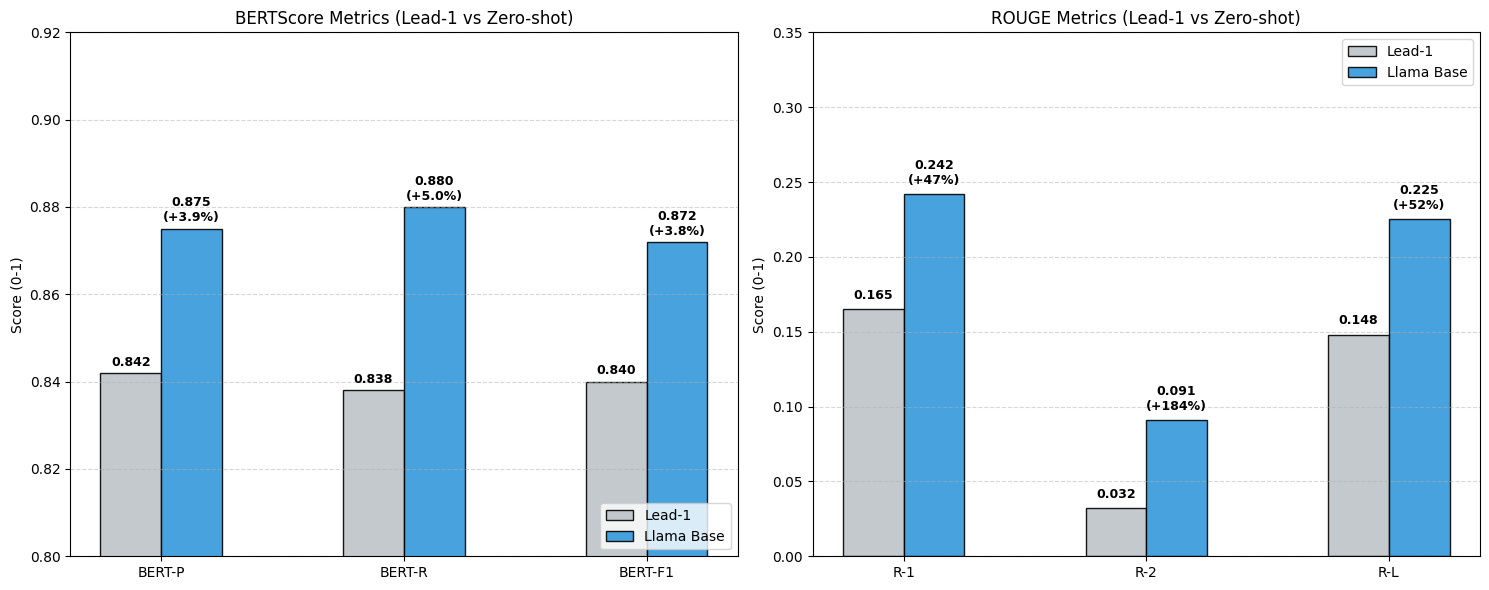

In [203]:
data_pair = [
    {
        'name': 'Lead-1',
        'bert_p': bert_lead1_precision, 'bert_r': bert_lead1_recall, 'bert_f1': bert_lead1_f1,
        'r1': rouge_lead1_res['rouge1'], 'r2': rouge_lead1_res['rouge2'], 'rl': rouge_lead1_res['rougeL']
    },
    {
        'name': 'Llama Base',
        'bert_p': bert_base_precision, 'bert_r': bert_base_recall, 'bert_f1': bert_base_f1,
        'r1': rouge_base_res['rouge1'], 'r2': rouge_base_res['rouge2'], 'rl': rouge_base_res['rougeL']
    }
]

print("График 1: Сравнение Baseline подходов")
plot_models_comparison(data_pair, "(Lead-1 vs Zero-shot)")

## 7. Итоговое решение: LoRA Fine-Tuning
Для дообучения использовалась технология **QLoRA** (Quantized Low-Rank Adaptation).

**Как это работает?**
Вместо обновления всех весов огромной модели (что невозможно на бесплатной GPU), мы:
1.  Замораживаем основную модель и квантуем её в **4 бита** (для экономии памяти).
2.  Внедряем маленькие обучаемые матрицы ранга $r=16$ в слои Attention (`q_proj`, `v_proj` и др.).
3.  Обучаемся предсказывать следующий токен на парах данных, минимизируя Loss только на части **Ответа** (Response), используя `SFTTrainer`.

In [151]:

from transformers import TrainingArguments
from trl import SFTTrainer

model = prepare_model_for_kbit_training(baseline_model)

peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    lora_dropout=0.2,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"])


--- ЗАПУСК ОБУЧЕНИЯ (STABLE) ---


In [152]:


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,


    eval_strategy="steps",
    eval_steps=10,
    logging_steps=10,
    logging_first_step=True,
    save_strategy="steps",
    save_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="loss",


    learning_rate=5e-6,
    fp16=True,
    optim="paged_adamw_32bit",
    lr_scheduler_type="cosine",
    report_to="none"
)

In [153]:
from transformers import EarlyStoppingCallback
from trl import DataCollatorForCompletionOnlyLM

response_template = "Response:\n"

collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,       # <-- ПЕРЕДАЕМ ВАЛИДАЦИЮ СЮДА
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [154]:
import warnings
warnings.filterwarnings("ignore")

In [155]:
print("Начинаем обучение...")
trainer.train()

Начинаем обучение...


Step,Training Loss,Validation Loss
10,3.339100,3.349051
20,3.103200,3.178996
30,3.044800,3.085386
40,3.001200,3.022624
50,2.836900,2.974025
60,2.825700,2.944628
70,2.930200,2.919301
80,2.734600,2.894116
90,2.798100,2.876067
100,2.789300,2.861747


TrainOutput(global_step=250, training_loss=2.8233409881591798, metrics={'train_runtime': 1149.3463, 'train_samples_per_second': 3.48, 'train_steps_per_second': 0.218, 'total_flos': 5252318899912704.0, 'train_loss': 2.8233409881591798, 'epoch': 2.0})

## График обучения (получился шумный изза маленького batch_size и частого логирования)

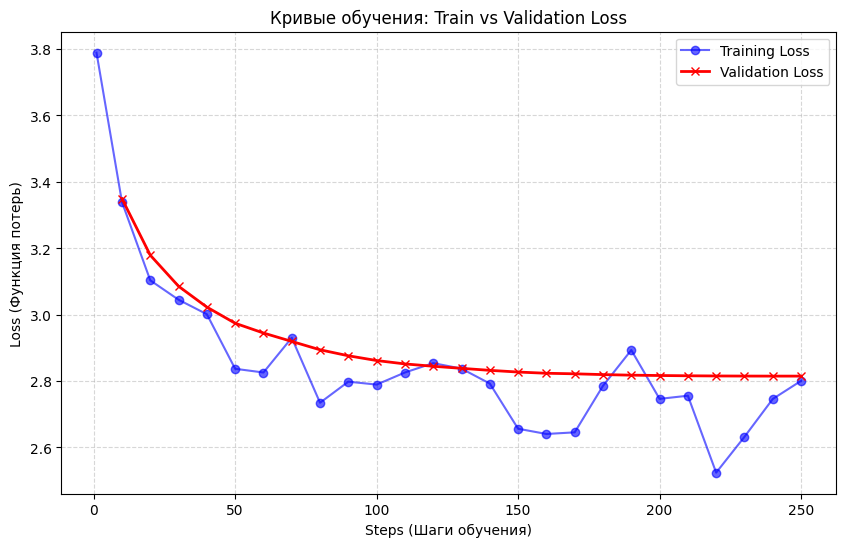

Финальный Train Loss: 2.8005
Финальный Eval Loss:  2.8148


In [156]:
import matplotlib.pyplot as plt

# Достаем историю логов
history = trainer.state.log_history

# Списки для графиков
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

# Проходим по истории и разделяем метрики
for entry in history:
    if 'loss' in entry: # Это лог обучения
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry: # Это лог валидации
        eval_steps.append(entry['step'])
        eval_loss.append(entry['eval_loss'])

# Строим график
plt.figure(figsize=(10, 6))

# Линия обучения
plt.plot(train_steps, train_loss, label='Training Loss', color='blue', marker='o', alpha=0.6)

# Линия валидации
# Она может быть короче или иметь другие шаги, это нормально
plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red', marker='x', linewidth=2)

plt.title('Кривые обучения: Train vs Validation Loss')
plt.xlabel('Steps (Шаги обучения)')
plt.ylabel('Loss (Функция потерь)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# Вывод последних значений текстом
print(f"Финальный Train Loss: {train_loss[-1]:.4f}")
if eval_loss:
    print(f"Финальный Eval Loss:  {eval_loss[-1]:.4f}")
else:
    print("Eval Loss не был рассчитан (проверьте параметры eval_steps)")

In [165]:

print("\n--- ЗАПУСК ВАЛИДАЦИИ (ПОСЛЕ ОБУЧЕНИЯ) ---")
model.config.use_cache = True
trainer.model.eval()

finetuned_preds = []

for text in tqdm(start_samples):
    summary = generate_summary(text, trainer.model, tokenizer)
    finetuned_preds.append(summary)

torch.cuda.empty_cache()


--- ЗАПУСК ВАЛИДАЦИИ (ПОСЛЕ ОБУЧЕНИЯ) ---


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


In [166]:
bert_tune_precision, bert_tune_recall, bert_tune_f1, rouge_tune_res, = metrics_count(finetuned_preds, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 8. Результаты и выводы
Финальное сравнение трех подходов представлено на графике.

*   **Fine-tuned (LoRA)** показала наилучший результат по обеим метрикам.
*   **Прирост ROUGE:** по сравнению с Zero-shot. Это значит, модель уловила «телеграфный» стиль заголовков Amazon.
*   **BERTScore:** вырос, что говорит о сохранении фактологической точности при сильном сжатии текста.

**Вывод:** Дообучение позволило лучше адаптировать модель под датасет, но больший прирост дало переход от эвристического метода до использования LLM



График 2: Финальное сравнение (эффект от обучения)


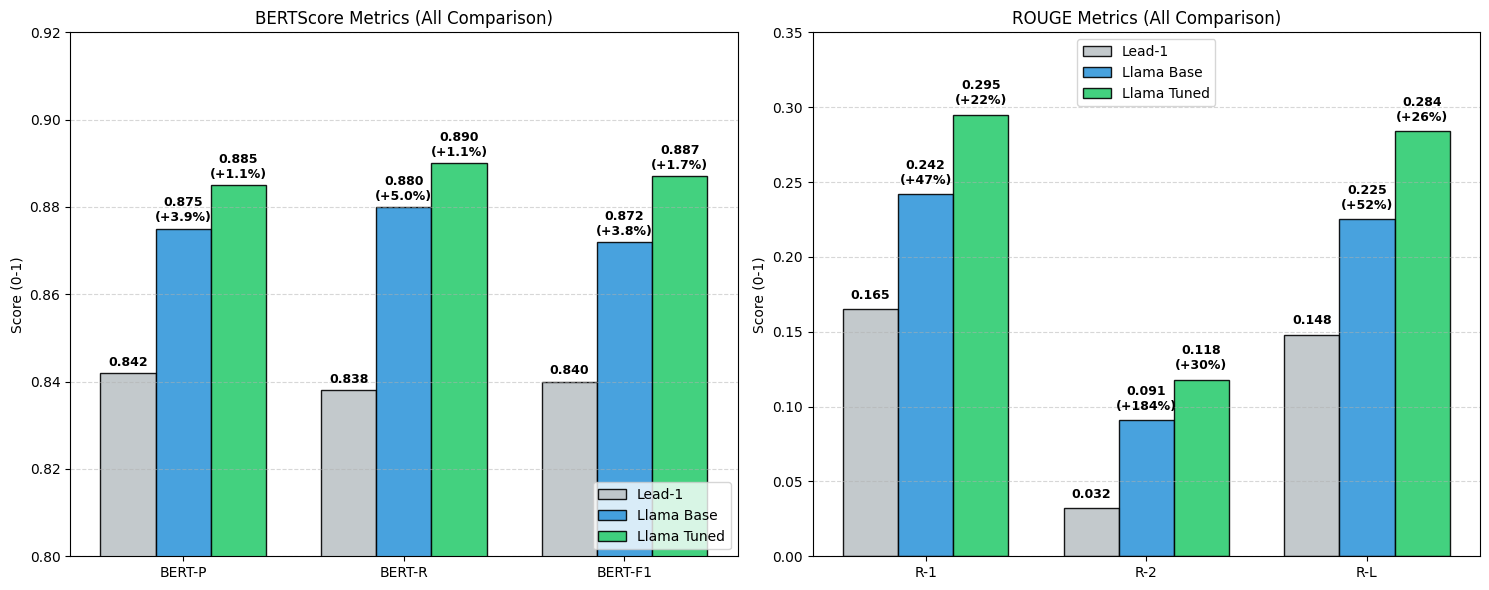

In [204]:

data_triplet = data_pair + [
    {
        'name': 'Llama Tuned',
        'bert_p': bert_tune_precision, 'bert_r': bert_tune_recall, 'bert_f1': bert_tune_f1,
        'r1': rouge_tune_res['rouge1'], 'r2': rouge_tune_res['rouge2'], 'rl': rouge_tune_res['rougeL']
    }
]

print("\n" + "="*50 + "\n")
print("График 2: Финальное сравнение (эффект от обучения)")
plot_models_comparison(data_triplet, "(All Comparison)")

## Еще примеры. Видно что дообученная версия больше похожа на референс и более лаконична

In [181]:
print("REVIEW: ", start_samples[1], "\n-------------")
print("lead1: ", lead1_preds[1], "\n-------------")
print("base llama: ", baseline_preds[1], "\n-------------")
print("tunned llama: ", finetuned_preds[1], "\n-------------")
print("reference: ", references[1], "\n-------------")

REVIEW:  He came in from the back yard about 8 hours after application, panting, heart racing. I thought he was overheated and didn't put two and two together until the next day. The veterinarians staff said they have lost many, many cats to this product. I cannot believe it is still being manufactured and sold. 
-------------
lead1:  He came in from the back yard about 8 hours after application, panting, heart racing. 
-------------
base llama:  A comprehensive review of the pet food line, highlighting the potential health risks and potential adverse effects from ingesting certain pet food products and ingredients. 
-------------
tunned llama:  This cat food has killed my cat! It contains an ingredient that is not approved for use by the FDA as a dietary supplement. This company should be sued for selling this poisonous product. 
-------------
reference:  This stuff almost killed my cat! 
-------------


In [206]:
print("REVIEW: ", start_samples[3], "\n-------------")
print("lead1: ", lead1_preds[3], "\n-------------")
print("base llama: ", baseline_preds[3], "\n-------------")
print("tunned llama: ", finetuned_preds[3], "\n-------------")
print("reference: ", references[3], "\n-------------")

REVIEW:  Everywhere I look, I see a Palm. I finally decided to see what the big deal was. I was not impressed with my Win CE machine (I like MS, just not in a handheld) so it took a while before I'd try this. I'm an immediate convert! I never knew there was so much you could do with a Palm and I'm VERY glad the IIIxe comes with 8 megs. I almost bought a IIIe, just because I'm a cheapskate- glad I didn't! I used 4 megs in the first week. Books, games, addresses, star charts, you name it, it's out there!Only gets 4 stars because I dropped it less than 2 feet and cracked the screen. Take my advice- get a STRONG case for it and/or buy the screen replacement warrenty from Palm. $100 to replace the screen, $30 (or so) for the warrenty. 
-------------
lead1:  Everywhere I look, I see a Palm. 
-------------
base llama:  Thanks for your review of the Palm IIIxe. It's great to hear that so many things can be done with such a small device. But, I wonder if you gave the IIxe enough credit for its 

In [183]:
review1 = "Christopher Nolan’s Inception is a sleek, mind-bending thriller that turns the idea of dreams into a high-stakes heist. The film balances complex rules with real emotional weight, especially through Leonardo DiCaprio’s conflicted performance. Its practical action, striking visuals, and pulsing score keep the tension high, while the layered structure rewards repeat viewings. Even when it feels intellectually dense, it never forgets to be entertaining—and the ending still sparks debate."

review2 = "Peter Jackson’s The Lord of the Rings: The Fellowship of the Ring is a near-perfect introduction to an epic world. It takes its time building Middle-earth through detail, atmosphere, and character, making the journey feel both magical and grounded. The friendships—especially between Frodo, Sam, and the rest of the Fellowship—give the story heart, while the action sequences are thrilling and clear. It’s the kind of film that makes adventure feel meaningful."

review3 = "Quentin Tarantino’s Pulp Fiction is bold, unpredictable, and endlessly quotable. The non-linear storytelling keeps you engaged, but it’s the sharp dialogue and memorable characters that make the film iconic. From tense stand-offs to darkly funny conversations, it constantly shifts tone without losing control. It’s not for everyone, but if you enjoy stylish crime stories with attitude and originality, it’s a classic."

review4 = "Steven Spielberg’s Jurassic Park remains one of the most exciting adventure films ever made. The sense of wonder when the dinosaurs first appear is still powerful, and the suspenseful set pieces are expertly directed. The film blends science, awe, and danger in a way that feels timeless, supported by strong performances and a legendary score. Even decades later, it’s hard to beat the sheer thrill of watching this story unfold."

In [182]:
best_model = trainer.model

In [188]:
generate_summary(review1, best_model, tokenizer, True)

'Inception is an intriguingly twisted tale about dreams, reality, and the line between them all.'

In [192]:
generate_summary(review2, best_model, tokenizer, True)

'Fantastic! A great start to what promises to be an epic trilogy.'

In [194]:
generate_summary(review3, best_model, tokenizer, True)

'A masterpiece of cinema.'

In [198]:
generate_summary(review4, best_model, tokenizer, True)

'Jurassic Park is a masterpiece!'